In [7]:
import torch
from torch import nn
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import get_rays
from model import Voxels
from rendering import rendering

In [8]:
datapath = 'fox'
batch_size = 1024

o, d, target_px_values = get_rays(datapath,'train')
test_o, test_d, test_target_px_values = get_rays(datapath,'test')
dataloader = DataLoader(torch.cat((torch.from_numpy(o),torch.from_numpy(d),torch.from_numpy(target_px_values)),dim=1),
                        batch_size=batch_size,shuffle=True)

(90, 400, 400, 4)
(10, 400, 400, 4)


In [17]:
model = Voxels(scale=1)

In [18]:
img = rendering(model, torch.from_numpy(o[1]),torch.from_numpy(d[1]),8,12)

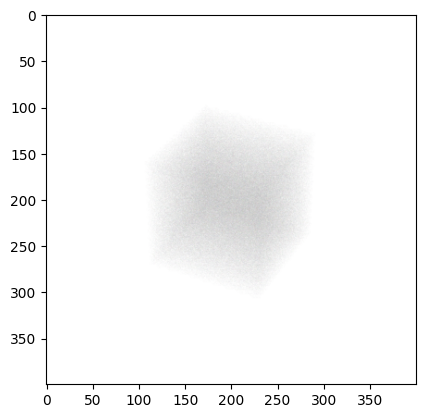

In [19]:
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())